# **Построение моделей сообществ**

## **Берем граф из первой работы**

In [ ]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests 
import time
import re
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
access_token = "0906a3e80906a3e80906a3e8630a15a86c009060906a3e86d098518b9ef19be9b4e879a"
basket = "62065987" # Баскетбол | Кронверкские барсы | ИТМО
foot = "77511653" # Футбол | Кронверкские барсы | ИТМО

In [ ]:
def get_group_members(group_id, access_token):
    members = []
    offset = 0
    count = 1000
    while True:
        params = {
            "group_id": group_id,
            "access_token": access_token,
            "v": "5.131",
            "offset": offset,
            "count": count,
        }
        response = requests.get("https://api.vk.com/method/groups.getMembers", params=params)
        if response.status_code == 200:
            data = response.json()
            members.extend(data["response"]["items"])
            offset += count
            if offset >= data["response"]["count"]:
                break
            time.sleep(0.1)
        else:
            print(f"Ошибка {response.status_code}: {response.text}")
            break
    return members


In [ ]:
basket_members = get_group_members(basket, access_token)
foot_members = get_group_members(foot, access_token)

In [ ]:
common_members = set(foot_members) & set(basket_members)

print(f"Количество пользователей, подписанных на оба сообщества: {len(common_members)}")

Количество пользователей, подписанных на оба сообщества: 90


In [ ]:
import networkx
import time
import collections
import numpy as np

In [ ]:
def get_friends_ids(user_id):
    params = {
          "user_id": user_id,
          "access_token": access_token,
          "v": "5.131",
    }
    
    json_response = requests.get('https://api.vk.com/method/friends.get' , params=params).json()
    count = 0
    if json_response.get('error'):
        if json_response.get('error')['error_msg'] == 'This profile is private':
          count += 1
        else:
          print(json_response.get('error'))
        return list(), count
    
    return json_response[u'response']['items'], count

In [ ]:
def get_friends_members(members):
    res = {}
    count = 0
    for member in members:
      time.sleep(0.1)
      friends, c = get_friends_ids(member)
      count += c
      res[member] = np.intersect1d(friends, members)
    print(f'Private profiles detected: {count} out of {len(members)}')  
    return res

In [ ]:
basket_members_friends = get_friends_members(basket_members)

Private profiles detected: 255 out of 1187


In [ ]:
foot_members_friends = get_friends_members(foot_members)

Private profiles detected: 154 out of 683


<ipython-input-21-1f7b4adecaef>:14: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos=networkx.nx_pydot.graphviz_layout(g,prog="neato")


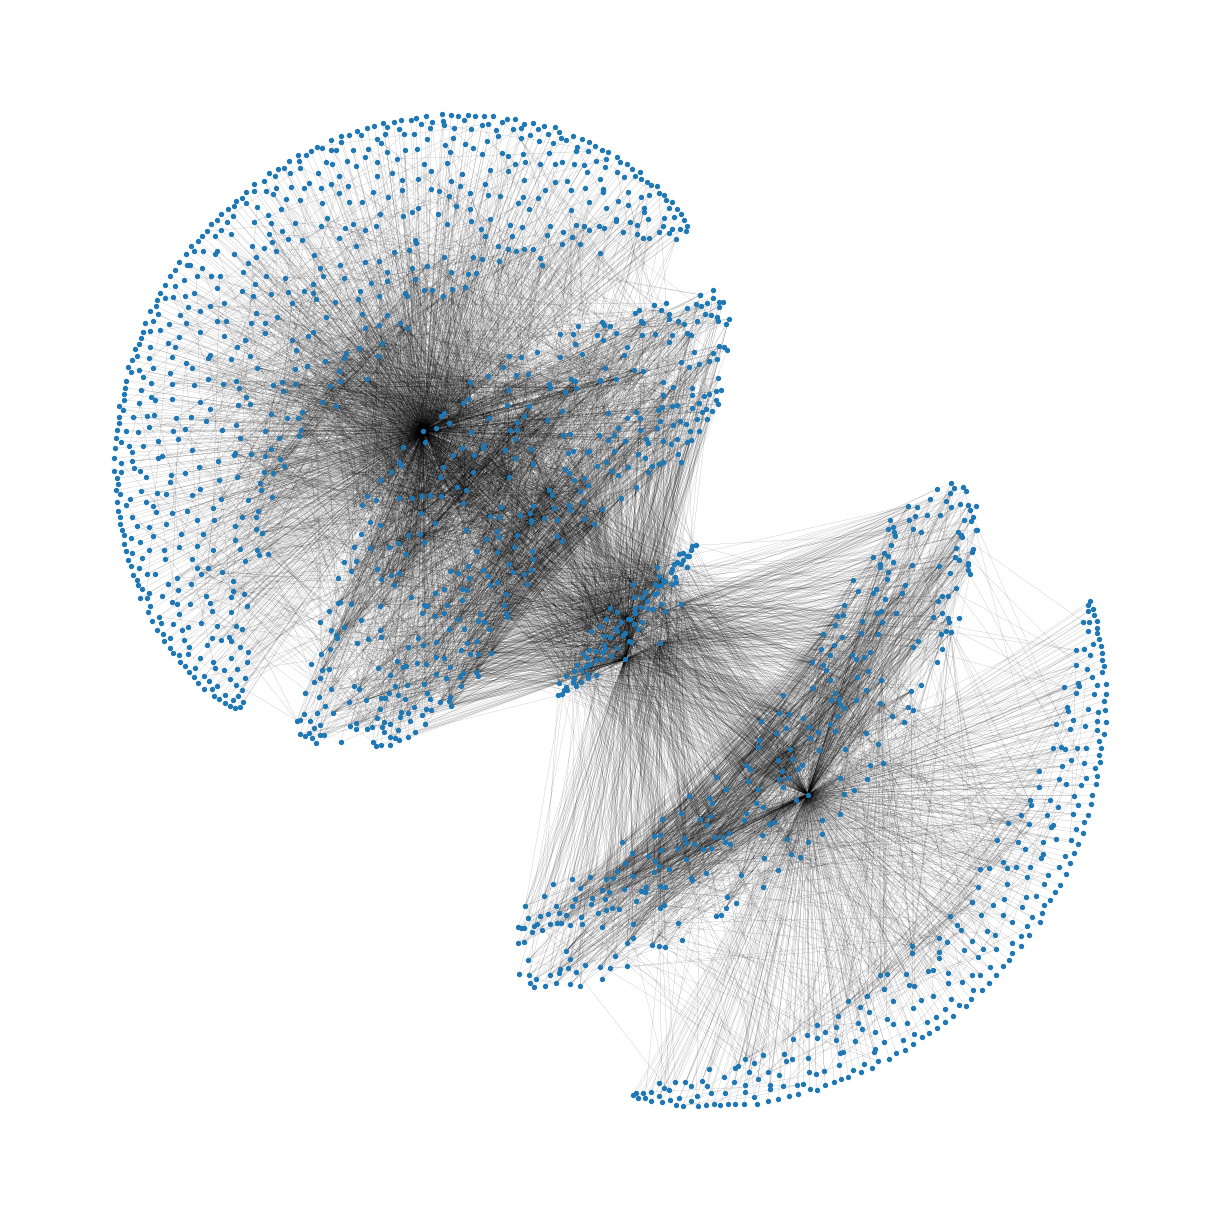

In [ ]:
g = networkx.Graph(directed=False)
g.add_node('basket')
for member in basket_members_friends:
  g.add_node(member)
  g.add_edge('basket', member)
  for friend in basket_members_friends[member]:
    g.add_edge(member, friend)
g.add_node('foot')
for member in foot_members_friends:
  g.add_node(member)
  g.add_edge('foot', member)
  for friend in foot_members_friends[member]:
    g.add_edge(member, friend)
pos=networkx.nx_pydot.graphviz_layout(g,prog="neato")
plt.figure(1,figsize=(12,12)) 
networkx.draw(g, pos, node_size=8, with_labels=False, width=0.06)
plt.show()

## **Задание 1**

Постройте функции распределения степеней узлов для обоих сообществ

In [ ]:
degree_sequence_basket = sorted([d for n, d in g.degree() if n != "foot"], reverse=True)
degree_sequence_foot = sorted([d for n, d in g.degree() if n != "basket"], reverse=True)

In [ ]:
degree_count_basket = collections.Counter(degree_sequence_basket)
degree_count_foot = collections.Counter(degree_sequence_foot)

deg_basket, cnt_basket = zip(*degree_count_basket.items())
deg_foot, cnt_foot = zip(*degree_count_foot.items())

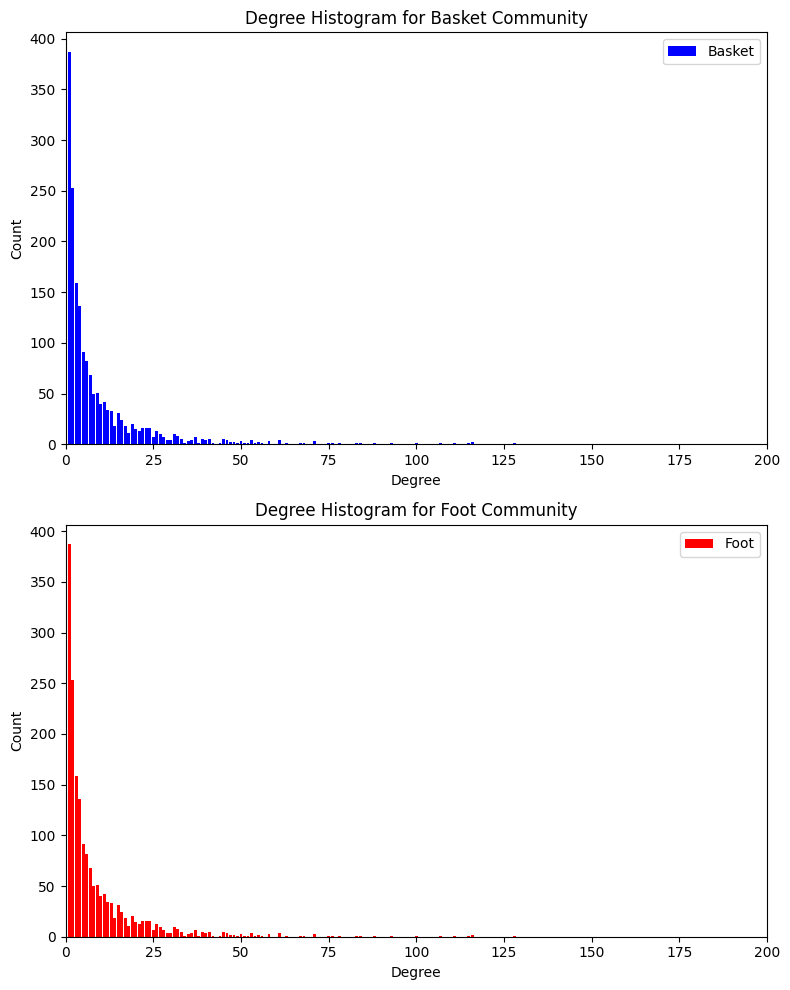

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))  


ax[0].bar(deg_basket, cnt_basket, width=0.80, color="b", label="Basket")
ax[0].set_title("Degree Histogram for Basket Community")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_xlim(0, 200)  
ax[0].legend()

ax[1].bar(deg_foot, cnt_foot, width=0.80, color="r", label="Foot")
ax[1].set_title("Degree Histogram for Foot Community")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0, 200)  
ax[1].legend()

plt.tight_layout()
plt.show()


Наши функции распределения являются логонормальными

## **Задание 2**

Вычислите кластерные коэффициенты обоих сообществ
Кластерный коэффициент (локальная плотность) - вероятность того, что два соседа в графе связаны между собой

In [ ]:
# Создаем подграфы для каждого сообщества
basket_subgraph = g.subgraph([node for node in g.nodes if node != "foot"])
foot_subgraph = g.subgraph([node for node in g.nodes if node != "basket"])

# Вычисляем кластерные коэффициенты для каждого узла в подграфе
basket_clustering_coefficients = networkx.clustering(basket_subgraph)
foot_clustering_coefficients = networkx.clustering(foot_subgraph)

# Вычисляем средний кластерный коэффициент для каждого сообщества
avg_basket_clustering_coefficient = sum(basket_clustering_coefficients.values()) / len(basket_clustering_coefficients)
avg_foot_clustering_coefficient = sum(foot_clustering_coefficients.values()) / len(foot_clustering_coefficients)

print("Средний кластерный коэффициент для сообщества Basket:", avg_basket_clustering_coefficient)
print("Средний кластерный коэффициент для сообщества Foot:", avg_foot_clustering_coefficient)


Средний кластерный коэффициент для сообщества Basket: 0.4221573735497601
Средний кластерный коэффициент для сообщества Foot: 0.3549946537177095


## **Задание 3**

Вычислите среднюю длину пути обоих графов

In [ ]:
# Находим связные компоненты в подграфах
connected_components_basket = list(networkx.connected_components(basket_subgraph))
connected_components_foot = list(networkx.connected_components(foot_subgraph))

# Вычисляем среднюю длину пути для каждой связной компоненты и находим среднее значение
avg_path_lengths_basket = []
avg_path_lengths_foot = []

for component in connected_components_basket:
    component_subgraph = basket_subgraph.subgraph(component)
    avg_path_length = networkx.average_shortest_path_length(component_subgraph)
    avg_path_lengths_basket.append(avg_path_length)

for component in connected_components_foot:
    component_subgraph = foot_subgraph.subgraph(component)
    avg_path_length = networkx.average_shortest_path_length(component_subgraph)
    avg_path_lengths_foot.append(avg_path_length)

# Вычисляем среднюю длину пути для каждого сообщества
mean_avg_path_length_basket = sum(avg_path_lengths_basket) / len(avg_path_lengths_basket)
mean_avg_path_length_foot = sum(avg_path_lengths_foot) / len(avg_path_lengths_foot)

print("Средняя длина пути для сообщества Basket:", mean_avg_path_length_basket)
print("Средняя длина пути для сообщества Foot:", mean_avg_path_length_foot)


Средняя длина пути для сообщества Basket: 0.049927730968983695
Средняя длина пути для сообщества Foot: 0.03736532552757582


## **Задание 4**
Изучите существующие модели социальных сетей. Какую (или какие) из них напоминают исследуемые графы?
На практике не всегда получается подогнать сообщество под одну из существующих моделей, но вычисленные вами метрики помогут оценить сходство. Оцените, попадают ли получившиеся значения метрик в диапазоны оценок известных моделей, и с какой точностью определены характерные значения в вашем случае. В этом вам может помочь следующая таблица:

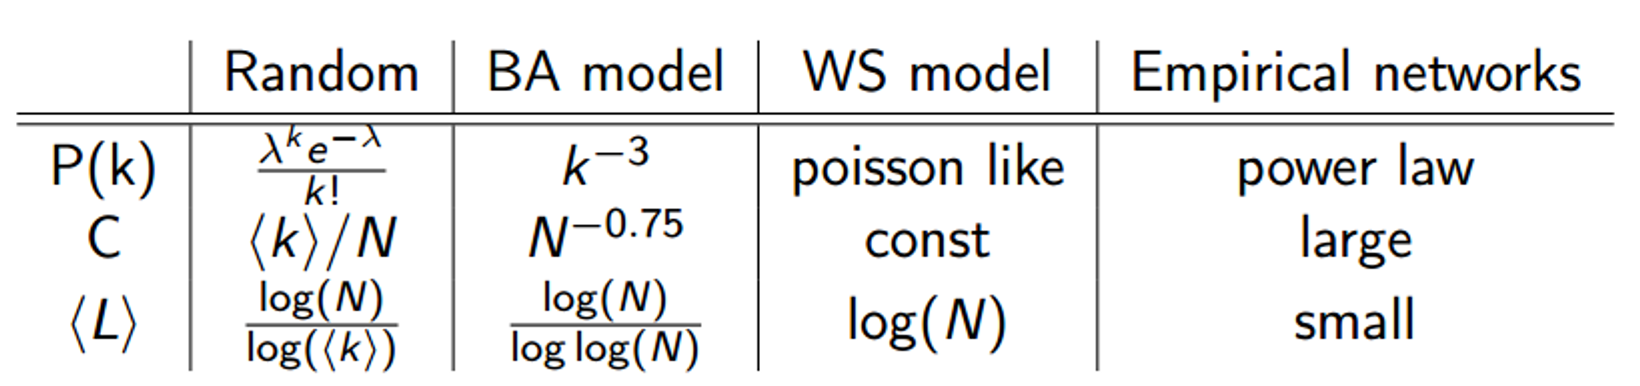

Наша модель является Emperical network, она имеет такую же функцию распределение, а также похожие диапазоны оценки